In [1]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import sys
import imageio.v3 as imageio
from pathlib import Path
from glob import glob
from scipy.signal import correlate
from scipy.signal import convolve2d
from tqdm import tqdm
import cv2
from scipy.ndimage import zoom
import os
from skimage.filters import frangi
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import tifffile
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300


def vel_field(curr_frame, next_frame, win_size, segment, corr_thresh):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            seg_win = segment[y : y + win_size, x : x + win_size]
            if np.sum(seg_win) < 5:
                continue
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            corr_check = cross_corr.max() / np.sum(abs(cross_corr))
            if corr_check > corr_thresh:
                dys[iy, ix], dxs[iy, ix] = (
                    np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                    - np.array([win_size, win_size])
                    + 1
                )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys


def get_max_stack(pics, noise_thresh):
    frame = imageio.v3.imread(pics[0])
    frame_res = frame.shape
    frame_max = frame.copy()

    for pic in tqdm(pics):
        pic_frame = imageio.v3.imread(pic)
        frame_max = np.maximum(frame_max, pic_frame)
    if noise_thresh > 0:
        frame_max = np.greater(frame_max, noise_thresh)
    return frame_max


def calc_arclength_arr(coords):
    coords = np.array(coords)
    u_arr = np.zeros((len(coords)))
    coords2 = np.zeros(coords.shape)
    coords2[1:] = coords[:-1]
    coords2 = coords2.T
    coords = coords.T
    coords_dx = coords2[0] - coords[0]
    coords_dy = coords2[1] - coords[1]
    coords_dr = np.sqrt(coords_dx**2 + coords_dy**2)
    u_arr[1:] = np.cumsum(coords_dr[1:])
    return u_arr


def curve_map_iter(image, iterations=3):
    kernel_n = np.array([[0.5, 1, 0.5], [1, -10, 1], [0.5, 1, 0.5]])
    for i in range(iterations):
        img_neighbors = convolve2d((image > 0) * 1, kernel_n, mode="same")
        img_neighbors = np.where(img_neighbors > 0, img_neighbors, np.nan)
        img_adj_sum = convolve2d(image, kernel_n, mode="same")
        #         img_adj_sum = np.where(img_adj_sum > 0, img_adj_sum, 0)
        image_out = np.where(img_neighbors > 0, img_adj_sum / img_neighbors, 0)
        image += image_out

    return np.where(image > 0, image, np.nan)

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/gpfs/scratch1/shared/amftrackflow/temp


2023-07-11 14:53:26.334223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 14:53:26.579154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/util-linux/2.36-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/libsodium/1.0.18-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/OpenPGM/5.2.122-GCCcore-10.3.0/lib:/sw

In [16]:
videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"

video_of_interest = "/TransportROOT/DATA/20230407_Plate777/001/"

To work with individual edges of 20230407_Plate777_001, here is a list of their indices:
edge 0, (8, 4)


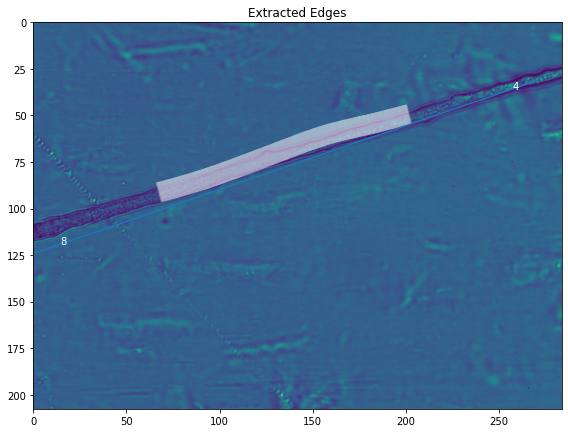

Saved the extracted edges


In [17]:
if os.path.exists(analysis_folder + video_of_interest + "video_data.json"):
    video_info_frame = pd.read_json(
        analysis_folder + video_of_interest + "video_data.json", orient="index"
    )[0]
    #     print(video_info_frame['fps'])
    analysis_obj = Kymo_video_analysis(input_frame=video_info_frame)
    analysis_obj.plot_extraction_img(target_length=70)

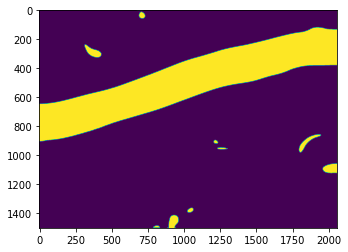

In [18]:
fig, ax = plt.subplots()
ax.imshow(analysis_obj.segmented)

In [19]:
image = imageio.imread(analysis_obj.selection_file[0])
target_length = 50

for edge in tqdm(analysis_obj.edge_objects):
    edge_skeleton = analysis_obj.nx_graph_pruned.get_edge_data(
        edge.edge_name[0], edge.edge_name[1]
    )["pixel_list"]
    u_arr = calc_arclength_arr(edge_skeleton) * analysis_obj.space_pixel_size
    arc_map = np.zeros(image.shape).astype(float)
    dist_array = np.ones(image.shape).astype(np.uint8)
    for i, coord in enumerate(edge_skeleton):
        arc_map[coord] = u_arr[i]
        dist_array[coord] = 0
    width_map = cv2.distanceTransform(dist_array, cv2.DIST_L2, 5)
    width_map = np.where(width_map < target_length, width_map, np.nan)
    curve_map = curve_map_iter(arc_map.copy(), iterations=target_length)
    map_intersect = ~np.isnan(width_map) * ~np.isnan(curve_map)
    tiff_out = [
        np.where(map_intersect, width_map, np.nan),
        np.where(map_intersect, curve_map, np.nan),
    ]
    tifffile.imwrite(
        f"{analysis_folder + video_of_interest}/edge {edge.edge_name}/PIV_mask.tiff",
        tiff_out,
    )

/scratch-local/svstaalduine/ipykernel_2267282/3906375882.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(analysis_obj.selection_file[0])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


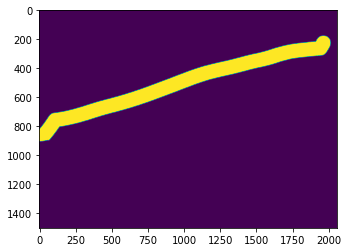

In [21]:
input_address = Path(videos_folder + video_of_interest)
analysis_path = Path(analysis_folder + video_of_interest)

video_address = input_address.joinpath("Img")

pics = [pic for pic in video_address.glob("*.tiff")]

piv_masks = np.ones(image.shape)
for edge in analysis_obj.edge_objects:
    piv_mask = np.isnan(
        tifffile.imread(
            f"{analysis_folder + video_of_interest}/edge {edge.edge_name}/PIV_mask.tiff"
        )[0]
    )
    piv_masks *= piv_mask
segment = (piv_masks == 0) * analysis_obj.segmented
fig, ax = plt.subplots()
ax.imshow(segment)


if not os.path.exists(analysis_path.joinpath("PIV/")):
    os.makedirs(analysis_path.joinpath("PIV/"))
pivanal_path = analysis_path.joinpath("PIV/")

In [36]:
frame_skip = 3
pics = [pic for pic in video_address.glob("*.tif")]

speed_thresh = 20 * analysis_obj.space_pixel_size
frame_range = np.arange(0, len(pics), frame_skip)

print(pics)

dxss = []
dyss = []

for i, frame_nr in enumerate(tqdm(frame_range)):
    if i == 0:
        continue
    else:
        curr_frame = cv2.GaussianBlur(
            imageio.v3.imread(pics[frame_range[i - 1]]), (3, 3), 0
        )
        next_frame = cv2.GaussianBlur(imageio.v3.imread(pics[frame_nr]), (3, 3), 0)
        _, _, dxs, dys = vel_field(curr_frame, next_frame, 6, segment * 1, 0.001)

        dxss.append(dxs)
        dyss.append(dys)

[PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00314.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00168.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00001.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00237.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00546.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00523.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00561.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/20230407_Plate777/001/Img/Img_00089.tif'), PosixPath('/gpfs/scratch1/shared/amftrackflow/videos/TransportROOT/DATA/2023040

  0%|                                                                                                                    | 0/200 [00:00<?, ?it/s]/scratch-local/svstaalduine/ipykernel_2267282/2955335675.py:39: RuntimeWarning: invalid value encountered in double_scalars
  corr_check = cross_corr.max() / np.sum(abs(cross_corr))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:18<00:00,  1.59s/it]


In [37]:
dxs = np.array([dxss, dyss])
print(dxs.shape)
dxs = dxs.transpose(1, 0, 2, 3)
tifffile.imwrite(pivanal_path.joinpath("PIVdxy.tiff"), dxs)

(2, 199, 251, 343)


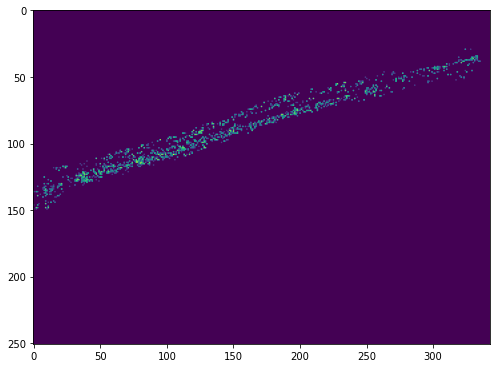

In [38]:
dxs = tifffile.imread(pivanal_path.joinpath("PIVdxy.tiff"))
dxs_plt = dxs * 255 / dxs.max()
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(dxs_plt[2][0].astype(np.uint8))
fig.tight_layout()

  0%|                                                                                                                    | 0/199 [00:00<?, ?it/s]/scratch-local/svstaalduine/ipykernel_2267282/3167469362.py:35: RuntimeWarning: Mean of empty slice
  vals_dx = np.nanmean(used_dx[vals_index].flatten())
/scratch-local/svstaalduine/ipykernel_2267282/3167469362.py:36: RuntimeWarning: Mean of empty slice
  vals_dy = np.nanmean(used_dy[vals_index].flatten())
/scratch-local/svstaalduine/ipykernel_2267282/3167469362.py:39: RuntimeWarning: Mean of empty slice
  kymograph_x[f] = np.nanmean(edge_video_dx, axis=1)
/scratch-local/svstaalduine/ipykernel_2267282/3167469362.py:40: RuntimeWarning: Mean of empty slice
  kymograph_y[f] = np.nanmean(edge_video_dy, axis=1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:53<00:00,  3.72it/s]


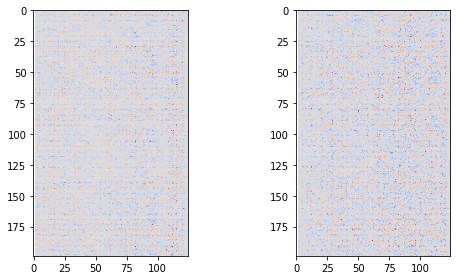

In [39]:
arc_bin_nr = 125
wid_bin_nr = 15
frame_nr = 0

kymograph_x = np.empty((len(dxs), arc_bin_nr))
kymograph_x[:] = np.nan
kymograph_y = np.empty((len(dxs), arc_bin_nr))
kymograph_y[:] = np.nan

used_dxy = dxs[0]
used_dy, used_dx = used_dxy

for edge in analysis_obj.edge_objects:

    width_mask, arc_mask = tifffile.imread(
        f"{analysis_folder + video_of_interest}/edge {edge.edge_name}/PIV_mask.tiff"
    )
    width_mask = cv2.resize(width_mask, used_dx.T.shape)
    arc_mask = cv2.resize(arc_mask, used_dx.T.shape)
    arc_bins = np.linspace(0, np.nanmax(arc_mask), arc_bin_nr)
    arc_index = np.digitize(arc_mask, arc_bins)
    width_bins = np.linspace(0, np.nanmax(width_mask), wid_bin_nr)
    width_index = np.digitize(width_mask, width_bins)

    for f in tqdm(range(len(dxs))):
        used_dxy = dxs[f]
        used_dy, used_dx = used_dxy

        edge_video_dx = np.empty((arc_bin_nr, wid_bin_nr))
        edge_video_dy = np.empty((arc_bin_nr, wid_bin_nr))
        edge_video_dx[:] = np.nan
        edge_video_dy[:] = np.nan

        for i, arc in enumerate(arc_bins):
            for j, width in enumerate(width_bins):
                vals_index = (arc_index == i) * (width_index == j)
                vals_dx = np.nanmean(used_dx[vals_index].flatten())
                vals_dy = np.nanmean(used_dy[vals_index].flatten())
                edge_video_dx[i][j] = vals_dx
                edge_video_dy[i][j] = vals_dy
        kymograph_x[f] = np.nanmean(edge_video_dx, axis=1)
        kymograph_y[f] = np.nanmean(edge_video_dy, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(kymograph_x, cmap="coolwarm")
    ax[1].imshow(kymograph_y, cmap="coolwarm")
    fig.tight_layout()

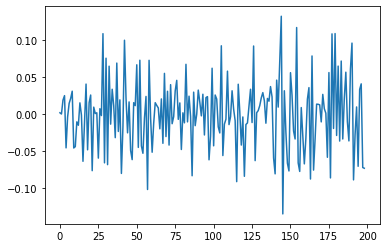

In [40]:
fig, ax = plt.subplots()
ax.plot(np.nanmean(kymograph_x, axis=1))

In [24]:
# space_res = .08625
space_res = 2 * 1.725 / 50 * 2
fps = 20
noise_thresh = 20

frame_max = get_max_stack(pics, noise_thresh)
frame = imageio.v3.imread(pics[0])
vid_dimen = frame.shape
frangi_range = range(30, 160, 30)
vid_frangi = frangi(frame, frangi_range)
vid_frangi = vid_frangi * (255 / np.max(vid_frangi))

vid_extent = [0, space_res * vid_dimen[1], 0, space_res * vid_dimen[0]]

segment = np.greater(vid_frangi, noise_thresh)

fag, ax = plt.subplots(figsize=(6, 6))
ax.imshow(segment, extent=vid_extent, aspect="auto", cmap="gray", vmin=0)
ax.set_xlabel("x ($\mu m$)")
ax.set_ylabel("y ($\mu m$)")
ax.set_title("Segmentation")

 38%|███████████████████████████████████████▊                                                                  | 222/591 [00:12<00:20, 18.18it/s]


KeyboardInterrupt: 

In [4]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2 * np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)
hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1, 2, 3, 0])
color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(
    analysis_path.joinpath("Analysis" + os.sep + "out.mp4"),
    color_out,
    fps=fps,
    quality=4,
)

2023-06-15 10:09:13,384-[WARNING]- imageio_ffmpeg:562 -> IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (512, 375) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


0
Found an xlsx file, using that data
              Unnamed: 0 Treatment Strain Time after crossing  \
5  20220118_Plate537_004  1%P100%N     C2              7 days   

   Growing temperature Position mm Unnamed: 6  dcenter mm  droot mm  \
5                 25.0       46260      43440         2.0       0.0   

  Bright-field (BF)\nor\nFluorescence (F) Binned (Y/N)  Magnification   FPS  \
5                                      BF            Y           50.0  20.0   

   Video Length (s) Comments  
5              30.0      NaN  
Analysing BRIGHT video of 50.0X zoom, with 20.0 fps
Using image selection 0 to 600
Succesfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


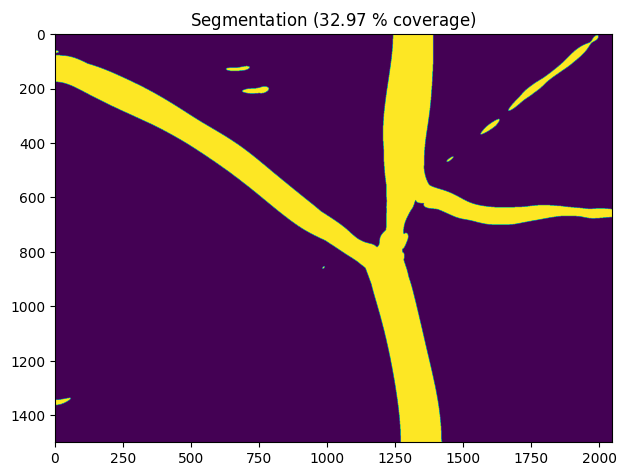

In [5]:
vid_analysis = Kymo_video_analysis(
    str(input_address),
    logging=True,
    vid_type=None,
    fps=None,
    binning=None,
    filter_step=80,
    seg_thresh=13,
    show_seg=True,
)


 To work with individual edges, here is a list of their indices:
edge 0, (22, 9)
edge 1, (17, 4)
edge 2, (23, 22)
edge 3, (26, 13)
edge 4, (31, 26)


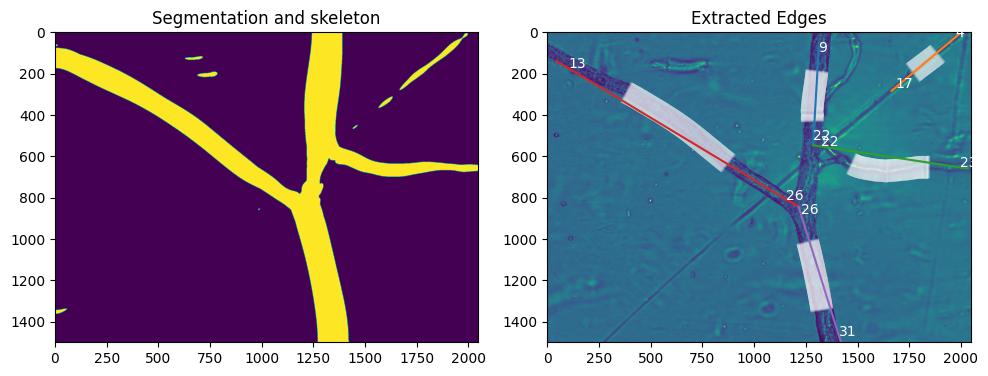

Saved the extracted edges


<Figure size 640x480 with 0 Axes>

In [6]:
edge_list = vid_analysis.edge_objects

### The print statement will give you the edge indices such that you can select which edges to analyze.
print("\n To work with individual edges, here is a list of their indices:")
for i, edge in enumerate(edge_list):
    print("edge {}, {}".format(i, edge.edge_name))

### Target length here determines the *width* of the analysis box.
### Too shallow, and you won't capture the entire hypha, too big and the analysis is plagued with background.
target_length = int(1.9 * vid_analysis.magnification)

vid_analysis.plot_extraction_img(target_length=target_length, save_img=True)

(200, 375, 512, 3)
375 512


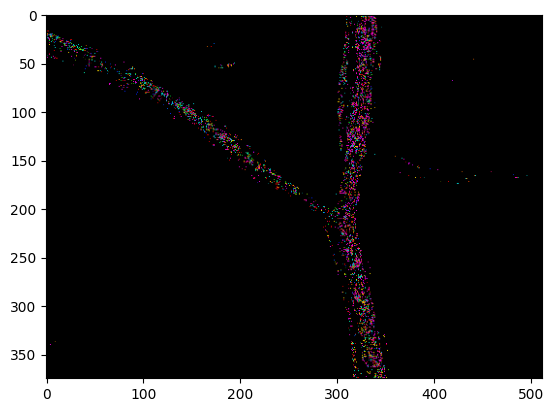

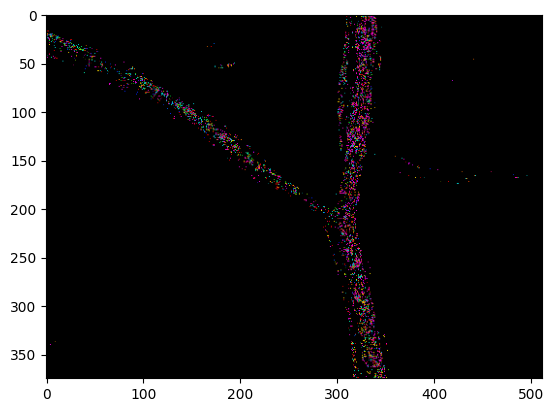

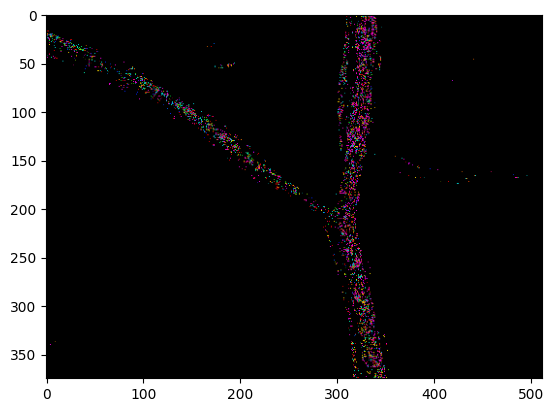

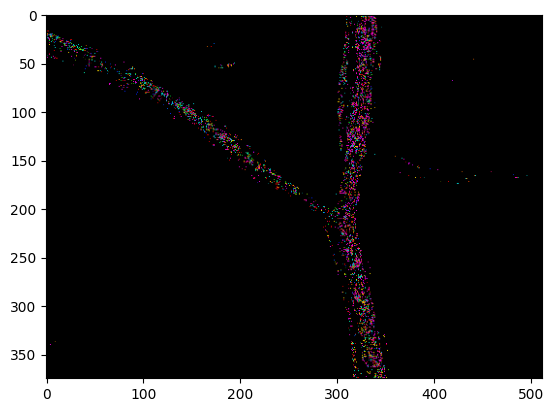

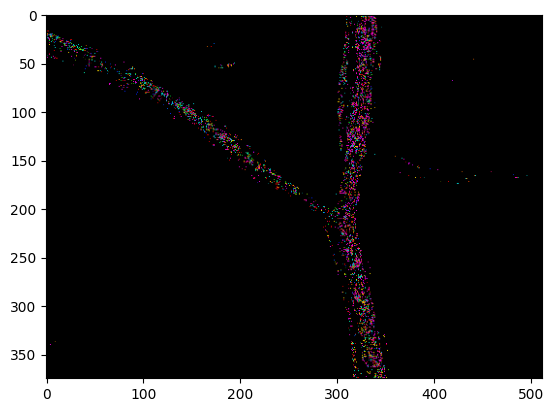

In [7]:
kernel = np.ones((3, 3), np.uint8)
color_size = [np.shape(color_out)[2], np.shape(color_out)[1]]
print(np.shape(color_out))
print(frame_res[0] // 4, frame_res[1] // 4)

for i, edge in enumerate(edge_list):
    edge_mask_start = np.zeros(frame_res)
    start_node, end_node = (edge.edge_name[0], edge.edge_name[1])
    edge_skel = edge.video_analysis.nx_graph_pruned[start_node][end_node]["pixel_list"]
    for coord in edge_skel:
        edge_mask_start[coord] = 1
    edge_mask = cv2.dilate(edge_mask_start, kernel, iterations=target_length // 2)
    edge_mask = cv2.resize(edge_mask, color_size)
    fig, ax = plt.subplots()
    ax.imshow(color_out[0])

In [38]:
images = [img_path for img_path in pivanal_path.glob("*.png")]
images = sorted(images)
# images = [img_adr for img_adr in glob(img_address)]
frame = cv2.imread(str(images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(
    str(analysis_path.joinpath("PIV_video.mp4")),
    cv2.VideoWriter_fourcc(*"MP4V"),
    10,
    (width, height),
)
for image in images:
    video.write(cv2.imread(str(image)))

cv2.destroyAllWindows()
video.release()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (128, 94) to (128, 96) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


(300, 94, 128, 3)


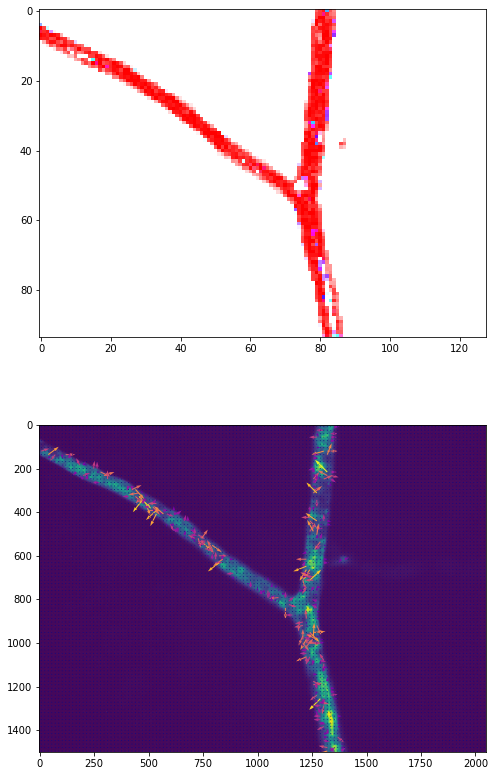

In [21]:
norms_adj = np.where(np.array(norms) < 20, norms, 0)
hues = (np.array(oris) + np.pi) / (2 * np.pi)
vals = np.array(norms_adj) / np.max(norms_adj)
sats = np.ones(hues.shape)

hsvs = np.array([hues, vals, sats])
hsvs = np.transpose(hsvs, axes=[1, 2, 3, 0])

color_out = np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8)
# color_out = zoom(color_out, (1.0, 128, 128, 1))


print(color_out.shape)
# print(np.array(hsv_to_rgb(hsvs) * 256, dtype=np.uint8))

hsvs_mean = hsv_to_rgb(np.max(hsvs, axis=0))

imageio.mimwrite(video_address.joinpath("out.mp4"), color_out, fps=fps, quality=4)

fig, ax = plt.subplots(2, figsize=(8, 14))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax[1].quiver(
    xs,
    ys,
    np.where(norm_drs < 20, dxs, 0),
    np.where(norm_drs < 20, dys, 0),
    np.where(norm_drs < 20, norm_drs, 0),
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax[1].imshow(imageio.v3.imread(pics[-1]))
ax[0].imshow(hsvs_mean)
ax[0].set_aspect("equal")
# ax[1].imshow(np.max(oris, axis=0), cmap='coolwarm', vmin= -np.pi, vmax=np.pi)
plt.show()